# Data Exploration and Predictive Modeling


In this notebook, we will explore a dataset with information concerning anonymized payment information for credit card holders. This data will be used to predict wether or not someone will default on their payments. In order to make these predictions, we fist mush inspect and clean the data, once we do that, we can train a predictive model. The data will be split up in order to test and validate the accuracy of our model.

Here is a description of each of the columns in the dataset.

**1. ID:** ID of each client <br>
**2. LIMIT_BAL:** Amount of given credit in NT dollars (includes individual and family/supplementary credit<br>
**3. SEX:** Gender (1=male, 2=female)<br>
**4. EDUCATION:** (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)<br>
**5. MARRIAGE:** Marital status (1=married, 2=single, 3=others)<br>
**6. AGE:** Age in years<br>
**7. PAY_0:** Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months,8=payment delay for eight months, 9=payment delay for nine months and above)<br>
**8. PAY_2:** Repayment status in August, 2005 (scale same as above)<br>
**9. PAY_3:** Repayment status in July, 2005 (scale same as above)<br>
**10. PAY_4:** Repayment status in June, 2005 (scale same as above)<br>
**11. PAY_5:** Repayment status in May, 2005 (scale same as above)<br>
**12. PAY_6:** Repayment status in April, 2005 (scale same as above)<br>
**13. BILL_AMT1:** Amount of bill statement in September, 2005 (NT dollar)<br>
**14. BILL_AMT2:** Amount of bill statement in August, 2005 (NT dollar)<br>
**15. BILL_AMT3:** Amount of bill statement in July, 2005 (NT dollar)<br>
**16. BILL_AMT4:** Amount of bill statement in June, 2005 (NT dollar)<br>
**17. BILL_AMT5:** Amount of bill statement in May, 2005 (NT dollar)<br>
**18. BILL_AMT6:** Amount of bill statement in April, 2005 (NT dollar)<br>
**19. PAY_AMT1:** Amount of previous payment in September, 2005 (NT dollar)<br>
**20. PAY_AMT2:** Amount of previous payment in August, 2005 (NT dollar)<br>
**21. PAY_AMT3:** Amount of previous payment in July, 2005 (NT dollar)<br>
**22. PAY_AMT4:** Amount of previous payment in June, 2005 (NT dollar)<br>
**23. PAY_AMT5:** Amount of previous payment in May, 2005 (NT dollar)<br>
**24. PAY_AMT6:** Amount of previous payment in April, 2005 (NT dollar)<br>
**25. default.payment.next.month:** Default payment (1=yes, 0=no)<br>

#### The target feature we will be predicting is "default.payment.next.month"




### Here are the imports of all the libraries that I used

In [1]:
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

%matplotlib inline

This dataframe has 25 features, which is more than Pandas will display by default. This line of code is used to change that setting. 

In [2]:
pd.set_option('display.max_columns', 26)

##### Loading the dataset into a Pandas DataFrame

In [3]:
data_path = 'UCI_Credit_Card.csv'

df = pd.read_csv(data_path)

The first thing I like to do when looking at a new dataset, is to use a very useful library called pandas-profiling, which will show us many useful statistics about the data, and the features. We can do this by calling the profile_report() function on the dataframe.

In [4]:
df.profile_report()

A profile report is usually a good way to get a feel for the data; such as checking for missing values, finding correlations, seeing how the data is distributed. 
  
We will use this function later. 

In [5]:
def plt_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_pred)
    labels = ['DID Default' if label == 1 else 'Did NOT Default' for label in labels]
    cols = ['Predicted {}'.format(label) for label in labels]
    index = ['Actual {}'.format(label) for label in labels]
    conf_mat_table = pd.DataFrame(confusion_matrix(y_true, y_pred), columns=cols, index=index)
    return sns.heatmap(conf_mat_table, annot=True, fmt='d');

# Data Exploration and Visualization

The first step to any Machine Learning model is to explore the data you are working with. A great way to do this is by visualizing it with charts and graphs. </br>

This is also a perfect time to check for outliers in the data. An Outlier is a point of data that is significantly different than the other data in that feature. It is good to remove outliers, as they can negatively effect the model. 

In [6]:
#Pandas .describe() function is very useful to see basic stats on a dataframe
df.describe()

ID       LIMIT_BAL           SEX     EDUCATION      MARRIAGE  \
count  30000.000000    30000.000000  30000.000000  30000.000000  30000.000000   
mean   15000.500000   167484.322667      1.603733      1.853133      1.551867   
std     8660.398374   129747.661567      0.489129      0.790349      0.521970   
min        1.000000    10000.000000      1.000000      0.000000      0.000000   
25%     7500.750000    50000.000000      1.000000      1.000000      1.000000   
50%    15000.500000   140000.000000      2.000000      2.000000      2.000000   
75%    22500.250000   240000.000000      2.000000      2.000000      2.000000   
max    30000.000000  1000000.000000      2.000000      6.000000      3.000000   

                AGE         PAY_0         PAY_2         PAY_3         PAY_4  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean      35.485500     -0.016700     -0.133767     -0.166200     -0.220667   
std        9.217904      1.123802      1.197186      1.196868      1.169139   
min       21.000000     -2.000000     -2.000000     -2.000000     -2.000000   
25%       28.000000     -1.000000     -1.000000     -1.000000     -1.000000   
50%       34.000000      0.000000      0.000000      0.000000      0.000000   
75%       41.000000      0.000000      0.000000      0.000000      0.000000   
max       79.000000      8.000000      8.000000      8.000000      8.000000   

              PAY_5         PAY_6      BILL_AMT1      BILL_AMT2     BILL_AMT3  \
count  30000.000000  30000.000000   30000.000000   30000.000000  3.000000e+04   
mean      -0.266200     -0.291100   51223.330900   49179.075167  4.701315e+04   
std        1.133187      1.149988   73635.860576   71173.768783  6.934939e+04   
min       -2.000000     -2.000000 -165580.000000  -69777.000000 -1.572640e+05   
25%       -1.000000     -1.000000    3558.750000    2984.750000  2.666250e+03   
50%        0.000000      0.000000   22381.500000   21200.000000  2.008850e+04   
75%        0.000000      0.000000   67091.000000   64006.250000  6.016475e+04   
max        8.000000      8.000000  964511.000000  983931.000000  1.664089e+06   

           BILL_AMT4      BILL_AMT5      BILL_AMT6       PAY_AMT1  \
count   30000.000000   30000.000000   30000.000000   30000.000000   
mean    43262.948967   40311.400967   38871.760400    5663.580500   
std     64332.856134   60797.155770   59554.107537   16563.280354   
min   -170000.000000  -81334.000000 -339603.000000       0.000000   
25%      2326.750000    1763.000000    1256.000000    1000.000000   
50%     19052.000000   18104.500000   17071.000000    2100.000000   
75%     54506.000000   50190.500000   49198.250000    5006.000000   
max    891586.000000  927171.000000  961664.000000  873552.000000   

           PAY_AMT2      PAY_AMT3       PAY_AMT4       PAY_AMT5  \
count  3.000000e+04   30000.00000   30000.000000   30000.000000   
mean   5.921163e+03    5225.68150    4826.076867    4799.387633   
std    2.304087e+04   17606.96147   15666.159744   15278.305679   
min    0.000000e+00       0.00000       0.000000       0.000000   
25%    8.330000e+02     390.00000     296.000000     252.500000   
50%    2.009000e+03    1800.00000    1500.000000    1500.000000   
75%    5.000000e+03    4505.00000    4013.250000    4031.500000   
max    1.684259e+06  896040.00000  621000.000000  426529.000000   

            PAY_AMT6  default.payment.next.month  
count   30000.000000                30000.000000  
mean     5215.502567                    0.221200  
std     17777.465775                    0.415062  
min         0.000000                    0.000000  
25%       117.750000                    0.000000  
50%      1500.000000                    0.000000  
75%      4000.000000                    0.000000  
max    528666.000000                    1.000000

Checking for Null values

In [7]:
df.isna().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

No missing values!

Next we will check the data types for each of the features.

In [8]:
df.dtypes

ID                              int64
LIMIT_BAL                     float64
SEX                             int64
EDUCATION                       int64
MARRIAGE                        int64
AGE                             int64
PAY_0                           int64
PAY_2                           int64
PAY_3                           int64
PAY_4                           int64
PAY_5                           int64
PAY_6                           int64
BILL_AMT1                     float64
BILL_AMT2                     float64
BILL_AMT3                     float64
BILL_AMT4                     float64
BILL_AMT5                     float64
BILL_AMT6                     float64
PAY_AMT1                      float64
PAY_AMT2                      float64
PAY_AMT3                      float64
PAY_AMT4                      float64
PAY_AMT5                      float64
PAY_AMT6                      float64
default.payment.next.month      int64
dtype: object

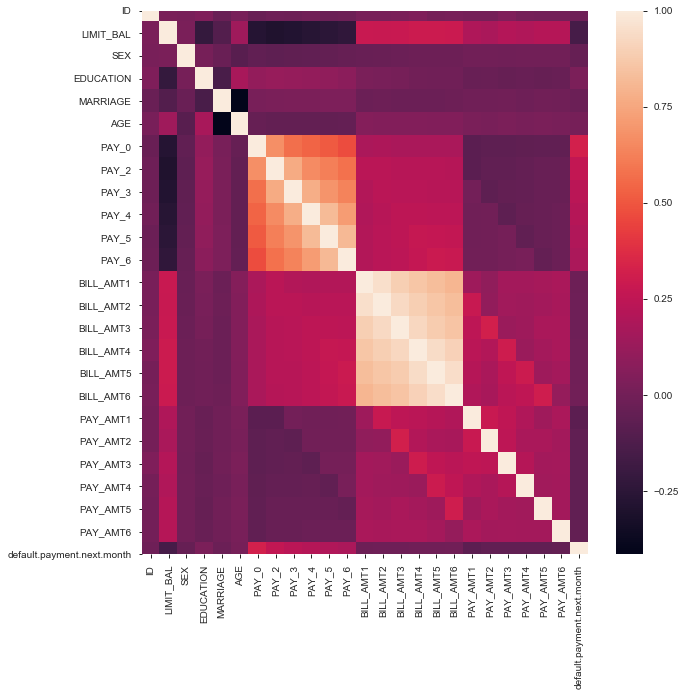

In [9]:
#Heatmap of this datasets correlation matrix

corrmat = df.corr()
fig = plt.figure(figsize=(10, 10))
sns.heatmap(corrmat)

This dataset contains both categorical and numeric features. We will look at them seperatly. 

## Categorical Variables
This dataset contains 3 categorical variables, they are **"SEX"**, **"EDUCATION"**, and **"MARRIAGE"**.

In [10]:
df[['SEX', 'EDUCATION', 'MARRIAGE']].describe()

SEX     EDUCATION      MARRIAGE
count  30000.000000  30000.000000  30000.000000
mean       1.603733      1.853133      1.551867
std        0.489129      0.790349      0.521970
min        1.000000      0.000000      0.000000
25%        1.000000      1.000000      1.000000
50%        2.000000      2.000000      2.000000
75%        2.000000      2.000000      2.000000
max        2.000000      6.000000      3.000000

In [11]:
df['SEX'].value_counts() #There appears to be more Women than Men in this dataset

2    18112
1    11888
Name: SEX, dtype: int64

In [12]:
df['EDUCATION'].value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

In [13]:
df['MARRIAGE'].value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

Both the **EDUCATION** and **MARRIAGE** features contain zeros, even though they should not. It is likley they were put there to signify a missing value. We can fix this later.

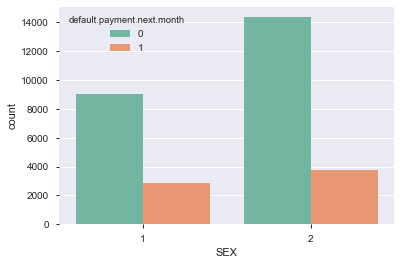

In [14]:
#compare the number of people who will default and who will not by sex
#1 = Male, 2 = Female
#0 = Did NOT Default, 1 = DID Default

# it seems that both sexes default at a similar rate


sns.countplot(x='SEX', data=df, palette=sns.color_palette('Set2'), hue='default.payment.next.month');

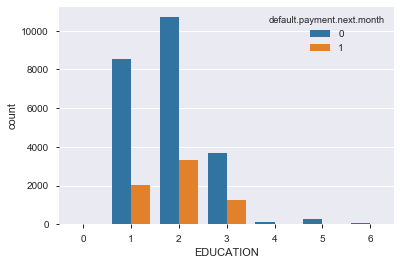

In [15]:
sns.countplot(x='EDUCATION', data=df, hue='default.payment.next.month');

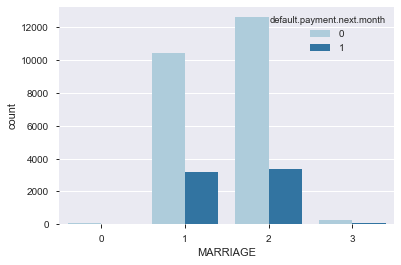

In [16]:
sns.countplot(x='MARRIAGE', data=df, hue='default.payment.next.month', palette='Paired');

#### Pairplot of the categorical features

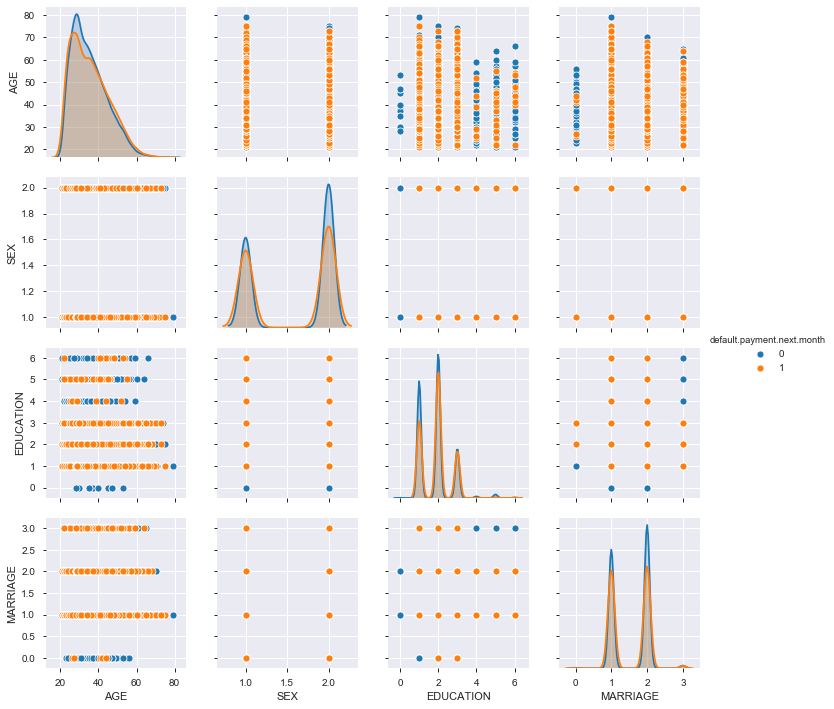

In [17]:
sns.pairplot(df, vars=['AGE', 'SEX', 'EDUCATION', 'MARRIAGE'], hue='default.payment.next.month');

Other than needing to fix the issue with those zeros, these features should be good to go for our model.

## Numeric Features


#### Feature "LIMIT_BAL" is the size of the line of credit to each person

#### Features prefixed with "PAY" are related to payment being delayed or misses, each one corrresponded to a month (April-Sept.)
 PAY_0  
 PAY_2  
 PAY_3  
 PAY_4  
 PAY_5  
 PAY_6  

#### Features prefixed with "BILL_AMT" is the bill ammout, each for a month April-Septmeber
 BILL_AMT1  
 BILL_AMT2  
 BILL_AMT3  
 BILL_AMT4  
 BILL_AMT5  
 BILL_AMT6  

#### Finally, features prefixed with "PAY_AMT" are for the last payment that was made
 PAY_AMT1  
 PAY_AMT2  
 PAY_AMT3  
 PAY_AMT4  
 PAY_AMT5  
 PAY_AMT6  
 
 
Here we will make histograms of the numeric features to check for outliers.  

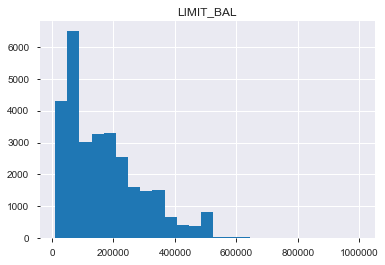

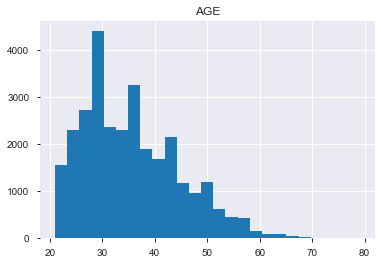

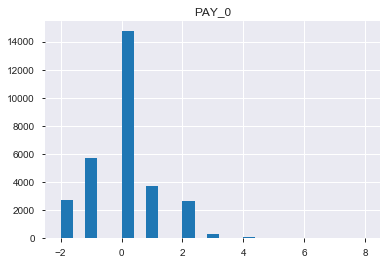

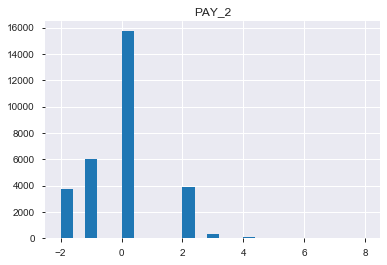

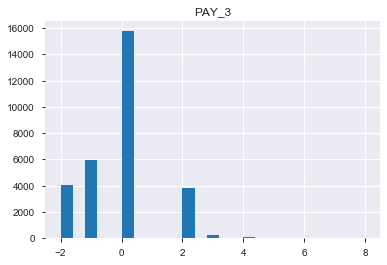

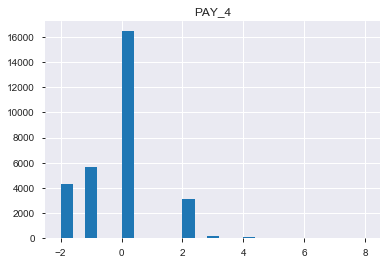

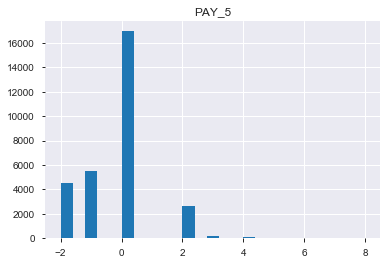

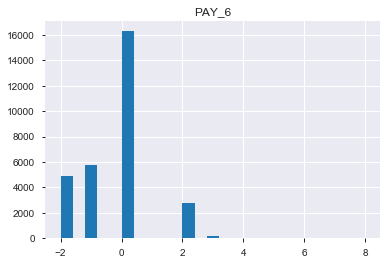

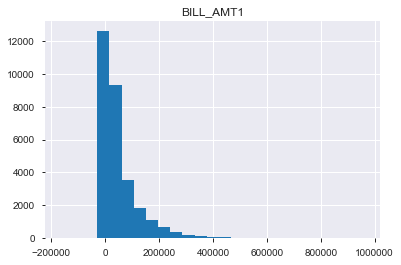

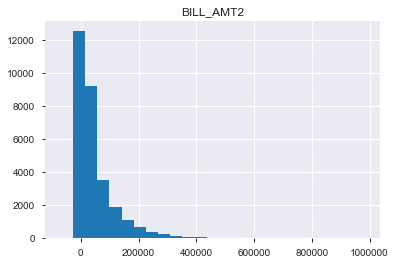

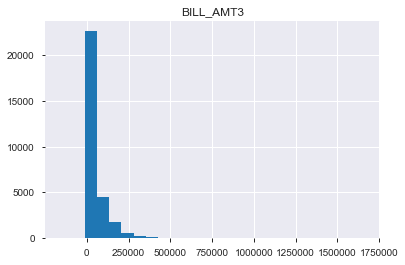

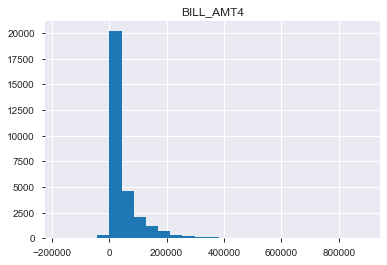

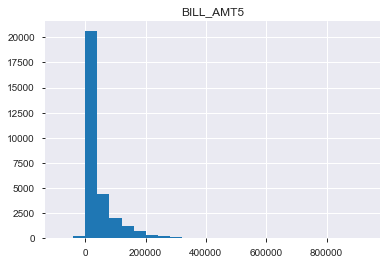

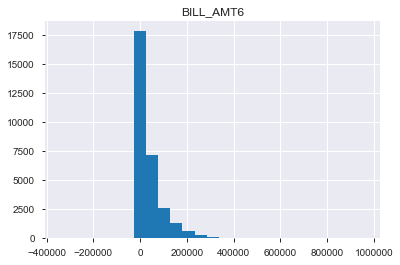

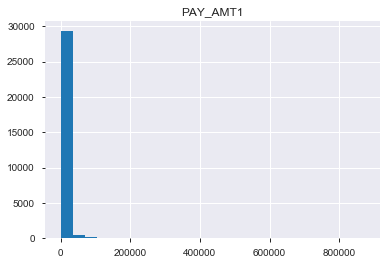

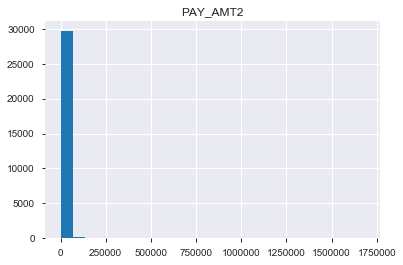

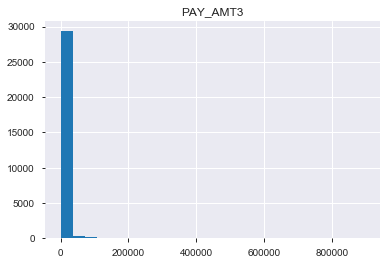

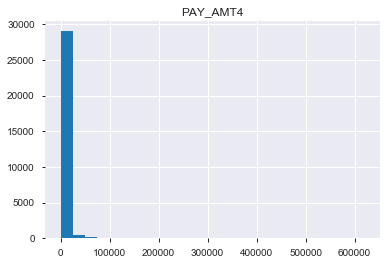

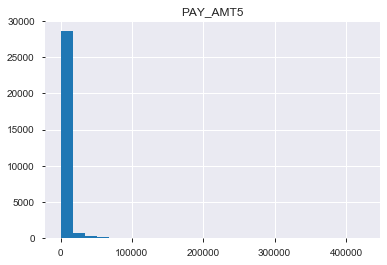

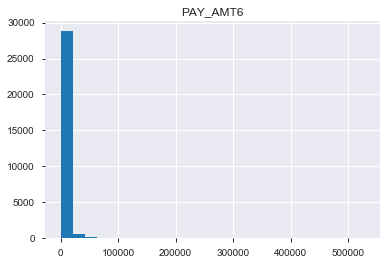

In [18]:
numeric = df.drop(columns=['ID', 'SEX', 'EDUCATION', 'MARRIAGE', 'default.payment.next.month'])

def simple_hist(col):
    numeric[col].hist(bins=25)
    plt.title(str(col))
    plt.show();

for col in numeric.columns:
    simple_hist(col)

These features seem good to go with few outliers. 

# Data Cleaning and Feature Engineering

Since this dataset is already pretty clean, there are only a few small things that must be done. 
  
  
First we will replace the zeros in the Eduction and Marriage columns with NaNs.

In [19]:
#replace zeros with nan in some cols
df[['EDUCATION', 'MARRIAGE']] = df[['EDUCATION', 'MARRIAGE']].mask((df['EDUCATION'] == 0) | (df['MARRIAGE'] == 0), other=np.nan)

And now confirm the changes took place correctly.

In [20]:
df[['EDUCATION', 'MARRIAGE']].isna().sum()

EDUCATION    68
MARRIAGE     68
dtype: int64

In [21]:
df[['EDUCATION', 'MARRIAGE']].describe()

EDUCATION      MARRIAGE
count  29932.000000  29932.000000
mean       1.852399      1.554590
std        0.788941      0.518277
min        1.000000      1.000000
25%        1.000000      1.000000
50%        2.000000      2.000000
75%        2.000000      2.000000
max        6.000000      3.000000

In the EDUCATION feature, the labels 4, 5, and 6 are all for either "Other" or "Unknown", we will turn all values of 4, 5, or 6 into one value. 


In [42]:
df['EDUCATION'] = df['EDUCATION'].replace([5, 6], 4)

In [43]:
df['EDUCATION'].unique()

array([ 2.,  1.,  3.,  4., nan])

# Predictive Modeling
### Now it is time to run out model. Since this is a classification problem, we will start with a RandomForestClassifier Model.
  
  
But first we will get out majority class baseline. This is the baseline accuracy if you were to predict the target class.

In [22]:
df['default.payment.next.month'].value_counts(normalize=True)

0    0.7788
1    0.2212
Name: default.payment.next.month, dtype: float64

Since only 22 percent of the cases resulted in defaulting on payment (remember 0 means they did NOT default, and 1 meaning they did), the class is imbalanced. THis means it is probably a good idea to not use accuracy to score how well our model performs. Instead something like ROC AUC should be used.  
  
  
  
  
Next, we will split the data. We do this so we can separate the data used to train and score the model.  
First we will split the dataframe into 2 parts, X, and a test set to test out final model at the end. X will then be split again into our train set, and validation set. 

In [23]:
X, test = train_test_split(df, test_size=0.2, random_state=42)
train, val = train_test_split(X, test_size=0.2, random_state=42)

train.shape, val.shape, test.shape

((19200, 25), (4800, 25), (6000, 25))

Now we isolate the target class (column "default.payment.next.month") from the rest of the data.

In [24]:
target = 'default.payment.next.month'

X_train = train.drop(columns=target)
X_val = val.drop(columns=target)

y_train = train[target]
y_val = val[target]

X_test = test.drop(columns=target)
y_test = test[target]

Not we will run out initial DecisionTree Model, it will be done within a SKLearn pipeline. We will also use the Simple Imputer from SKLearn to impute our few missing pieces of data. 
  
Then we will evaluate the models performance. 

In [25]:
pipeline = make_pipeline(
       SimpleImputer(strategy='median'),
       DecisionTreeClassifier(max_depth=50, min_samples_split=60, random_state=42)
)

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('simpleimputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)), ('decisiontreeclassifier', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=50,
            max_features=None, max_leaf_nodes=None,
            min_impur...        min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'))])

In [26]:
pipeline.score(X_val, y_val)

0.775625

That score is not too good, it is even worse than out baseline. That means this model is no better at predicting default than guessing. 
  
We will also check the models ROC AUC score, which is a score based on true and false positive rates. A score of 0.5 is considered baseline. 

In [27]:
y_pred = pipeline.predict(X_val)

print('Decision Tree ROC AUC:', roc_auc_score(y_val, y_pred))

Decision Tree ROC AUC: 0.6205056968940221


Text(0, 0.5, 'True Positives')

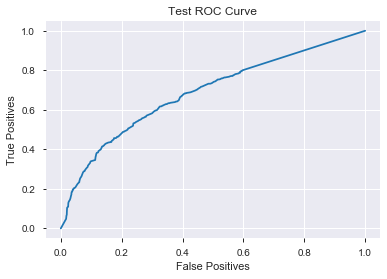

In [28]:
y_pred_proba = pipeline.predict_proba(X_val)[:, 1]


fpr, tpr, thresh = roc_curve(y_val, y_pred_proba)
plt.plot(fpr, tpr)
plt.title('Test ROC Curve')
plt.xlabel('False Positives')
plt.ylabel('True Positives')

Here we can also plot the feature importances to see which feature was the most important for this model. 

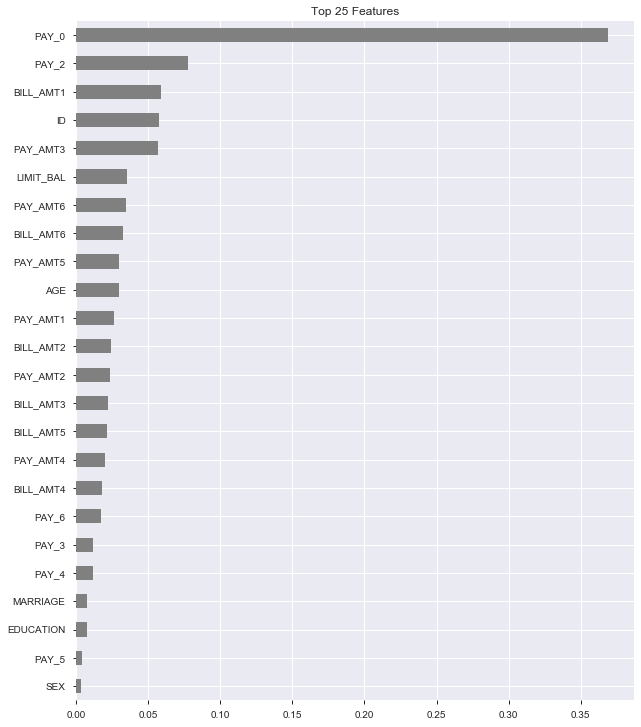

In [29]:
dt = pipeline.named_steps['decisiontreeclassifier']
importances = pd.Series(dt.feature_importances_, X_train.columns)

im = 25

plt.figure(figsize=(10, im/2))
plt.title('Top {} Features'.format(im))
importances.sort_values()[-im:].plot.barh(color='grey');


According to the above graph, the feature "PAY_0" was the most important feature for this model.
  
  
The next machine learning algorithm we will try is called XGBoost. More specifically the XGBoostClassifier. This model might give better results than the DecisionTreeClassifier.

In [30]:
pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('simpleimputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)), ('xgbclassifier', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_d...
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1))])

In [31]:
y_pred = pipeline.predict(X_val)
print('Valdidation Accuracy: ', accuracy_score(y_val, y_pred))
print('XGBoost ROC AUC:', roc_auc_score(y_val, y_pred))

Valdidation Accuracy:  0.815
XGBoost ROC AUC: 0.6452130482285001


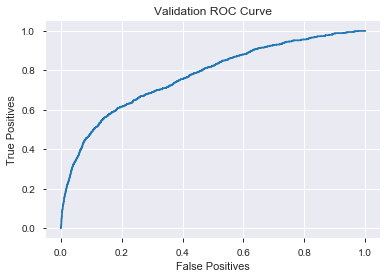

In [32]:
y_pred_proba = pipeline.predict_proba(X_val)[:, 1]


fpr, tpr, thresh = roc_curve(y_val, y_pred_proba)
plt.plot(fpr, tpr)
plt.title('Validation ROC Curve')
plt.xlabel('False Positives')
plt.ylabel('True Positives')
plt.show();

This model seemed to do much better. Both the accuracy score, and ROC AUC score increased. But we still have not done any hyperparameter tuning. A hyperparameter is a parameter  to the model that can be changed. Adjusting them correctly could help with the accuracy of the model.
  
For this we will go a Grid Search, which will compare many different parameter configuration, and return the best ones.
  
Since SKLearn pipelines don't work very will with XGBoost, we will impute or data first, and not use the pipeline.

In [33]:
imputer = SimpleImputer(strategy='median')

X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)
X_test_imputed = imputer.transform(X_test)

In [34]:
model = XGBClassifier(random_state=42, n_jobs=-1)

params = {
    'nthread':[4],
    'max_depth': (10, 25, 50, 75, 100, 150, 250, 500),
    'learning_rate':(0.2, 0.4, 0.6, 0.8),
    'n_estimators': [200, 300, 400, 500],
    'max_depth': range(50, 500, 50),
}

grid = GridSearchCV(
    estimator=model,
    param_grid=params,
    verbose=10,
    cv=3,
    scoring='roc_auc',
    refit=True,
    n_jobs=-1
)

In [35]:
grid.fit(X_train_imputed, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed: 1

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'nthread': [4], 'max_depth': range(50, 500, 50), 'learning_rate': (0.2, 0.4, 0.6, 0.8), 'n_estimators': [200, 300, 400, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=10)

In [36]:
print('Best Hyperparameters:', grid.best_params_)
print('Best Cross Validation Score:', grid.best_score_)

Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 50, 'n_estimators': 200, 'nthread': 4}
Best Cross Validation Score: 0.7542275583184458


Now that we have the most optimal hyperparameters, we can not use them in out final model, and use the test set of data to score its final performance. 

In [37]:
final_model = grid.best_estimator_

In [38]:
y_pred = final_model.predict(X_test_imputed)
y_pred_proba = final_model.predict_proba(X_test_imputed)[:, 1]

print('Final Model Accuracy Score:', accuracy_score(y_test, y_pred))
print('Final Model ROC AUC:', roc_auc_score(y_test, y_pred))

Final Model Accuracy Score: 0.8075
Final Model ROC AUC: 0.6445993690964507


It looks like out model performs about the same with the test data as our previous on does on the validation set. 
  
Now lets plot the ROC curve and plot a confusion matrix. 

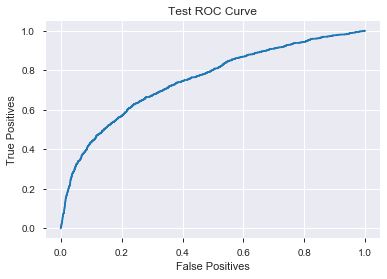

In [39]:
#plotting ROC AUC curve for the final model
fpr, tpr, thresh = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr)
plt.title('Test ROC Curve')
plt.xlabel('False Positives')
plt.ylabel('True Positives')
plt.show();

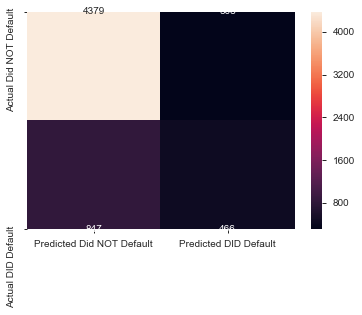

In [40]:
#function can be found at the top of the notebook
plt_confusion_matrix(y_test, y_pred)

We can also check out feature importances for the final model, and see if they changed from out initial model.

<Figure size 1080x1080 with 0 Axes>

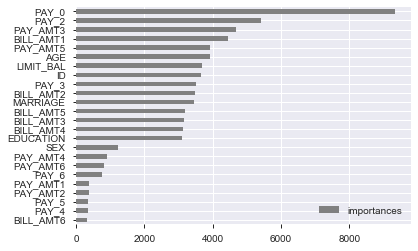

In [41]:
feature_important = final_model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = sorted(list(feature_important.values()))[::-1]
f_list = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23']
mapp = dict(zip(f_list, list(X_train.columns)))
index = [mapp[key] for key in keys]

data = pd.DataFrame(data=values, index=index, columns=['importances']).sort_values(by='importances', ascending=True)
plt.figure(figsize=(15, 15))
data.plot.barh(color='grey')
plt.show();

It looks like the feature 'PAY_0' is still the most important and 'PAY_2' is still in second place. 

# Conclusion

  
To conclude, our final model beats our majority class baseline using the test data. We were able to slightly improve our performance over a DecisionTree with an XGBoost model. Further tuning can be made to the XGBoost model with the grid search (or randomized search), but that can take some time due to the computational power required. Over all I am happy with an accuracy score of 80% and ROC AUC of 0.64